<a href="https://colab.research.google.com/github/Amey-M/Lip-Reader-Using-3DCNN-s/blob/main/Transling_Assistant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import imageio
from typing import List

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [4]:
LIP_MARGIN = 0.3
RESIZE = (140,46)

face_detector = dlib.get_frontal_face_detector()
landmark_detector = dlib.shape_predictor("/content/drive/MyDrive/TransLing Lip Detector/Dlib Detector/detector/shape_predictor_68_face_landmarks.dat")

In [5]:
def shape_to_list(shape):

    coords = []
    for i in range(0, 68):
        coords.append((shape.part(i).x, shape.part(i).y))

    return coords

In [6]:
def load_video(path:str) -> List[float]:

    vid = cv2.VideoCapture(path)

    frame_buffer = []
    frame_buffer_color = []

    while(True):

        success, frame = vid.read()                     # Read frame
        if not success: break                           # Break if no frame to read left

        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)   # Convert image into grayscale
        frame_buffer.append(gray)                       # Add gray-scale image to the frame buffer
        frame_buffer_color.append(frame)                # Add color image to the color frame buffer

    vid.release()

    landmark_buffer = []    # Used to store the Facial Landmarks

    for (i, image) in enumerate(frame_buffer):

        face_rects = face_detector(image,1)    #detect the faces in the frame

        if len(face_rects) < 1:
            print("No face detected")
            break

        if len(face_rects) > 1:
            print("Multiple faces detected")
            break

        rect = face_rects[0]

        landmark = landmark_detector(image, rect)    # used to detect landmarks
        landmark = shape_to_list(landmark)           # converting to list as dlib library output is in the 'shape' type
        landmark_buffer.append(landmark)            # Add the landmarks to the buffer

    cropped_buffer = []     # used to store the Lip landmarks

    for (i, landmark) in enumerate(landmark_buffer):

        lip_landmark = landmark[48:68] # landmarks corresponding to lips

        lip_x = sorted(lip_landmark,key = lambda pointx: pointx[0])     # Lip landmark sorted for determining lip region
        lip_y = sorted(lip_landmark, key = lambda pointy: pointy[1])

        x_add = int((-lip_x[0][0]+lip_x[-1][0])*LIP_MARGIN)                     # Determine Margins for lip-only image
        y_add = int((-lip_y[0][1]+lip_y[-1][1])*LIP_MARGIN)

        crop_pos = (lip_x[0][0]-x_add, lip_x[-1][0]+x_add, lip_y[0][1]-y_add, lip_y[-1][1]+y_add)
        cropped = frame_buffer_color[i][crop_pos[2]:crop_pos[3],crop_pos[0]:crop_pos[1]]        # Crop image
        cropped = cv2.resize(cropped,(RESIZE[0],RESIZE[1]),interpolation=cv2.INTER_CUBIC)       # Resize the image to desired shape

        cropped = tf.image.rgb_to_grayscale(cropped)

        cropped_buffer.append(cropped)


    mean = tf.math.reduce_mean(cropped_buffer)
    std = tf.math.reduce_std(tf.cast(cropped_buffer, tf.float32))

    return tf.cast((cropped_buffer - mean), tf.float32) / std

In [7]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [8]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size =40)


In [9]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [10]:
char_to_num(['a','m','e','y','!'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 1, 13,  5, 25, 29])>

In [11]:
num_to_char([ 1, 13,  5, 25]).numpy()

array([b'a', b'm', b'e', b'y'], dtype=object)

In [12]:
def load_alignments(path:str) -> List[str]:

    with open(path, 'r') as f:
        lines = f.readlines()

    tokens = []

    for line in lines:
        line = line.split()
        if line[2] != 'sil':

            tokens = [*tokens, ' ', line[2]]

    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [13]:
def load_data(path:str):
    path = bytes.decode(path.numpy())

    file_name = path.split('/')[-1].split('.')[0]
    video_path = os.path.join('/content','drive','MyDrive','TransLing Lip Detector', 'data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('/content','drive','MyDrive','TransLing Lip Detector', 'data', 'alignments', 's1', f'{file_name}.align')

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [14]:
test_path = '/content/drive/MyDrive/TransLing Lip Detector/data/s1/bbaf2n.mpg'

In [15]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [16]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39,  6, 39, 20, 23, 15,
       39, 14, 15, 23])>

In [17]:
frames.shape

TensorShape([75, 46, 140, 1])

In [18]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at f two now'>

In [19]:
def mappable_function(path:str) -> List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## CREATING THE DATA PIPELINE

In [20]:
def filter_files(file_path):

    files_to_remove = ['brwa4p.mpg', 'pbio7a.mpg', 'bwwuzn.mpg', 'sran9s.mpg', 'brwg8p.mpg', 'lrarzn.mpg', 'sbbh4p.mpg', 'Thumbs.db', 'pbwx1s.mpg', 'prii9a.mpg', 'lgbf8n.mpg', 'bbizzn.mpg']  # file names to remove
    file_name = tf.strings.split(file_path, os.path.sep)[-1]  # Extract the file name from the path

    return tf.math.logical_not(tf.reduce_any(tf.math.equal(file_name, files_to_remove)))

In [21]:
database = tf.data.Dataset.list_files('/content/drive/MyDrive/TransLing Lip Detector/data/s1/*.mpg')

k=0
for i in database:
    k=k+1
    if k==1:
        print(tf.strings.split(i, os.path.sep)[-1])

print(k)
print("************************")

database1 = database.filter(filter_files)

k=0
for i in database1:
    k=k+1
    if k==1:
        print(tf.strings.split(i, os.path.sep)[-1])

print(k)
print("************************")

tf.Tensor(b'lwal3s.mpg', shape=(), dtype=string)
1000
************************
tf.Tensor(b'pwwq8n.mpg', shape=(), dtype=string)
989
************************


In [22]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/TransLing Lip Detector/data/s1/*.mpg')  # get the files stored in the directory
data = data.filter(filter_files)
data = data.shuffle(500, reshuffle_each_iteration=False)  # shuffle the data for improved accuracy with parameter=500
data = data.map(mappable_function)  # apply mappable function to each video to get the cropped video of the lips and its alignments
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))  #take a batch of videos
data = data.prefetch(tf.data.AUTOTUNE)  # prefetch to reduce run-time

# for splitting into train and test

train = data.take(450)
train = train.repeat(count=-1)
test = data.skip(450)

In [23]:
test

<_SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [24]:
frames, alignments = data.as_numpy_iterator().next()

In [25]:
len(frames)

2

In [26]:
sample = data.as_numpy_iterator()

In [27]:
val = sample.next()
val[0].shape

(2, 75, 46, 140, 1)

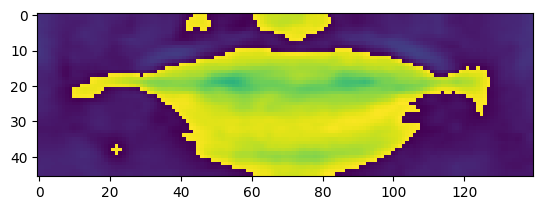

In [28]:
plt.imshow(val[0][0][40])

In [29]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place red with q two now'>

## Neural - Network

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [31]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [32]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

# More Powerful PC's can uncomment the following layers to better train the model
#model.add(Conv3D(256, 3, padding='same'))
#model.add(Activation('relu'))
#model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(128, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(64, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))


#model.add(Bidirectional(LSTM(64, kernel_initializer='Orthogonal', return_sequences=True)))
#model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 128)   442496    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 128)   0         
                                                        

In [34]:
yhat = model.predict(val[0])

1/1 [==============================] - 8s 8s/step


In [35]:
yhat.shape

(2, 75, 41)

In [36]:
tf.argmax(yhat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([ 8,  1,  1,  1,  1,  1,  1,  1,  8,  8,  1,  1,  1,  1,  1,  1,  1,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35,  1, 35,  1,  1,  1, 35,  1,  1,  1, 35,  1,
        1,  1,  1, 35, 35, 35,  9])>

In [37]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'haaaaaaahhaaaaaaa6666666666666666666666666666666666666666a6aaa6aaa6aaaa666i'>

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'haaaaaaahhaaaaaaa6666666666666666666666666666666666666666a6aaa6aaa6aaaa666i'>

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

## Training

In [41]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [45]:
checkpoint_callback = ModelCheckpoint(os.path.join('/content','drive','MyDrive','TransLing Lip Detector','models','checkpoint'), monitor='loss', save_weights_only=True)

In [46]:
schedule_callback = LearningRateScheduler(scheduler)

In [47]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, epochs=50, callbacks=[schedule_callback, checkpoint_callback], steps_per_epoch=100)

Epoch 1/50
100/100 [==============================] - 1011s 10s/step - loss: 108.7515 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - 1002s 10s/step - loss: 88.2771 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - 1009s 10s/step - loss: 83.7511 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - 1005s 10s/step - loss: 78.0874 - lr: 1.0000e-04
Epoch 5/50
100/100 [==============================] - 980s 10s/step - loss: 75.2141 - lr: 1.0000e-04
Epoch 6/50
100/100 [==============================] - 954s 10s/step - loss: 73.6275 - lr: 1.0000e-04
Epoch 7/50
100/100 [==============================] - 960s 10s/step - loss: 72.9572 - lr: 1.0000e-04
Epoch 8/50
100/100 [==============================] - 968s 10s/step - loss: 71.7320 - lr: 1.0000e-04
Epoch 9/50
100/100 [==============================] - 960s 10s/step - loss: 72.3434 - lr: 1.0000e-04
Epoch 10/50
100/100 [==============================] - 969s 10s/step - loss: 70.5167 -